Project reference for simulation part 1
https://github.com/juanhorgan/guitar_factory/blob/master/part%201/part_1.py


In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import simpy
import random

In [2]:
cycle_t = pd.read_csv('/Users/pedrorodriguez/Desktop/Springboard/Capstone Project/Raw_data/cycle_time_fixed')

In [3]:
#Calculating the production line capacity
cycle_t['station'] = cycle_t['station'].astype(object)
cycle_t['production_line'] = cycle_t['production_line'].astype(object)
cycle_t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5200 entries, 0 to 5199
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       5200 non-null   int64  
 1   station          5200 non-null   object 
 2   production_line  5200 non-null   object 
 3   Sample           5200 non-null   object 
 4   Cycle_time       5200 non-null   float64
 5   Ct_min           5200 non-null   float64
 6   Ct_hr            5200 non-null   float64
dtypes: float64(3), int64(1), object(3)
memory usage: 284.5+ KB


In [4]:
del cycle_t['Sample']
cycle_t.head()

,Unnamed: 0,station,production_line,Cycle_time,Ct_min,Ct_hr
0,0,1,1,96.200000,1.603333,0.026722
1,1,2,1,22.200000,0.370000,0.006167
2,2,3,2,7.250000,0.120833,0.002014
3,3,4,2,11.666667,0.194444,0.003241
4,4,5,2,75.250000,1.254167,0.020903


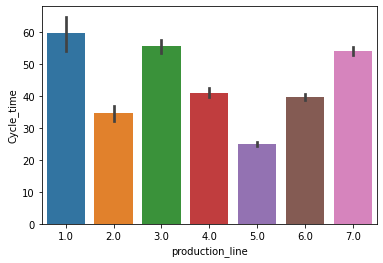

In [5]:
sns.barplot(data= cycle_t, x='production_line', y='Cycle_time')

It is needed to calculate the production line capacity before creating the simulation. 

In [6]:
ct_5 = cycle_t[cycle_t['production_line'] == 5.0]
del ct_5['Unnamed: 0']

In [7]:
cycle_5_t = ct_5.groupby('station').mean()
cycle_5_t = cycle_5_t.reset_index()
cycle_5_t.head()

,station,Cycle_time,Ct_min,Ct_hr
0,22.0,17.020000,0.283667,0.004728
1,23.0,13.008333,0.216806,0.003613
2,24.0,16.498750,0.274979,0.004583
3,25.0,28.129167,0.468819,0.007814
4,26.0,21.453333,0.357556,0.005959


In [8]:
#Capacity hourly
station_no = ct_5['station'].nunique()
shift_hr_day = 12
total_pd_line_capacity_hr = station_no * shift_hr_day

#Total Operator time to use machine
lunch_time = 0.5#hr
break_time = 0.5 #hr
shift_time = 12 #hr
total_operator_time = shift_hr_day - lunch_time - break_time
no_operator = station_no #The company have one operator per station, meaning that is the same number of station_no.

#Calculating the Production efficiency line 
time_one_unit = cycle_5_t['Ct_min'].max()
total_time_produced = (600/12)* time_one_unit
total_time_attended = no_operator *  total_operator_time
efficiency = ((total_time_produced)/total_time_attended)

#Calculating the production line capacity
capacity = ((total_pd_line_capacity_hr * total_operator_time)*efficiency)/2


print('The production line have', station_no, 'stations and is used by the operator', total_operator_time, 'hours per shift. \nThe total capacity of the production line per shift is', round(capacity,2), 'running with', round(efficiency*100, 2),'of efficiency.')

The production line have 18 stations and is used by the operator 11.0 hours per shift. 
The total capacity of the production line per shift is 984.29 running with 82.85 of efficiency.


In [9]:
production_line_capacity = capacity
dispatch_capacity = round(capacity/2,0)
dispatch_capacity

492.0

# Brainstorming

## How to create the algorithm for the simulations

**Process line idea**

1) The daily goal per shift is to produce 600 units, meaning that the first station has to have an input of a minimum of 50 units per hour to achieve the goal. The first station will have an output of 50 units per hour.

2) The units' processing time will be the average of the cycle time of each station.

3) The unit's waiting time will be the difference between the first and second stations. 

In [10]:
# Create a simple model for starting

class station:
    def __init__(self, env):
        self.unit = simpy.Container(env, capacity= capacity, init = 50)
        self.dispatch = simpy.Container(env, capacity = dispatch_capacity, init=0)

def operator(env, station):
    while True:
        yield station.unit.get(1)
        body_time = 1
        yield env.timeout(total_operator_time)
        yield station.dispatch.put(1)

In [11]:
env = simpy.Environment()
stations = station(env)

operator_process_line = env.process(operator(env, stations))

env.run(until = total_operator_time)

print(f'Dispatch has %d units ready to go!' % stations.dispatch.level)
print(f'----------------------------------')
print(f'SIMULATION COMPLETED')

Dispatch has 0 units ready to go!
----------------------------------
SIMULATION COMPLETED


# Second try!

In [18]:

def generate_interarrival():
    return np.random.exponential(60./50.0)

def generate_station2():
    return np.random.exponential(60./60.0)


def arrival_process(env, assamble):
    while True:
        yield env.timeout(generate_interarrival())
        print (env.now, 'units arrives')
        env.process(station(env, assamble))

def station(env, assamble):
    with assamble.request() as request:
        yield request
        print( env.now, 'units is being assamble')
        yield env.timeout(generate_station2())
        print( env.now, 'units departed')


env = simpy.Environment()

assamble = simpy.Resource(env, capacity=1)

env.process(arrival_process(env, assamble))

env.run(until=10)

1.014535604026983 units arrives
1.014535604026983 units is being assamble
1.0987251779432288 units departed
2.2487920535067873 units arrives
2.2487920535067873 units is being assamble
2.311728482140646 units arrives
3.108378769567622 units arrives
3.2169164620668926 units departed
3.2169164620668926 units is being assamble
3.5804827671131503 units departed
3.5804827671131503 units is being assamble
3.9683792321278855 units arrives
3.9920843884106034 units arrives
4.231158541825301 units departed
4.231158541825301 units is being assamble
5.024782295618935 units arrives
6.406561184248696 units departed
6.406561184248696 units is being assamble
7.223654824333883 units departed
7.223654824333883 units is being assamble
8.422866150836972 units departed
9.862739351338945 units arrives
9.862739351338945 units is being assamble
9.91885945345492 units departed
